<a href="https://colab.research.google.com/github/akankshakusf/Project-CNN-Deep-Learning-Malaria-Detection/blob/master/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#import packages

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

# **Data Preparation**

## Data Loading

In [61]:
# Import the Malaria dataset from TensorFlow Datasets (TFDS)
# and shuffle files
# Setting as_supervised=True returns the data as (image, label) pairs

dataset, dataset_info = tfds.load(
    "malaria", with_info=True,as_supervised=True, shuffle_files=True)


Scenario: lets say you dnt pull the data out from tensorflow instead you are pull it from you .text file. below is the approuch we will take

In [62]:
#function to split train data

def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    # Get dataset size
    DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()

    # Make train, val, test split
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))  # Skip train data
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))  # skip Remaining data as test

    return train_dataset, val_dataset, test_dataset

In [ ]:
###### split function logic explaination builder ######

# TRAIN_RATIO=0.6
# VAL_RATIO=0.2
# TEST_RATIO=0.2
# TOTAL=10
# #set range on data for testing logic
# ds=tf.data.Dataset.range(TOTAL)
# #train_sd,val_ds,test_ds=split(ds,TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# train_ds=ds.take(int(TRAIN_RATIO*TOTAL))
# val_test_ds=ds.skip(int(TRAIN_RATIO*TOTAL)) #not important
# val_ds=val_test_ds.take(int(VAL_RATIO*TOTAL))
# test_ds=val_test_ds.skip(int(VAL_RATIO*TOTAL))

# #print main dataset for review
# print([int(x) for x in ds.as_numpy_iterator()])
# print([int(x) for x in train_ds.as_numpy_iterator()])
# print([int(x) for x in val_test_ds.as_numpy_iterator()])
# print([int(x) for x in val_ds.as_numpy_iterator()])
# print([int(x) for x in test_ds.as_numpy_iterator()])


In [63]:
# Shuffle dataset before splitting
dataset = dataset["train"].shuffle(buffer_size=10000, reshuffle_each_iteration=False)

In [64]:
# Define split ratios
# split it into three parts:
# - The first 80% of the data will be used for training.
# - The next 10% (80%-90%) will be used for validation
# - The last 10% (90%-100%) will be used for testing.
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Call split function
train_dataset, val_dataset, test_dataset = split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [65]:
# Check dataset sizes
print(f"Training size: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Training size: 22046
Validation size: 2755
Test size: 2757


In [66]:
#check data info
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

So, in the data 0 represent parasitic
and 1 represents uneffected

In [67]:
# Print a few values from the validation dataset
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(133, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


## Dataset Visualization

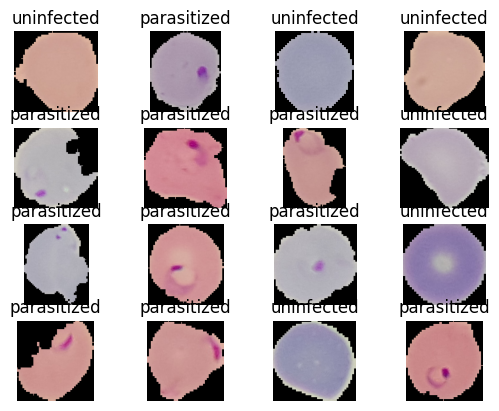

In [68]:
for i, (image, label) in enumerate(train_dataset.take(16)):  #Unpack tuple
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy())  # Convert Tensor to NumPy array
    plt.title(dataset_info.features['label'].int2str(label.numpy()))  # Convert label to class name
    plt.axis("off")

plt.show()

## Data Preprocessing

### Data Augmentation

- These images are of bigger sizes (255,255,3) etc. But we will have to Normalize them and bring them in the range of 0-1 so Deep learningn model converges or inference faster

In [69]:
#define the image size we want to reduce to
IM_SIZE=224
BATCH_SIZE=32

def resize_rescale(image, label):
    # Resize and rescale the image
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0
    return image, label

# Apply the function to the dataset
train_dataset = train_dataset.map(resize_rescale).shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [70]:
#view for verification
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)

Image shape: (32, 224, 224, 3)
Label: tf.Tensor([1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1], shape=(32,), dtype=int64)


* see that image size is now 224 : of shape shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)
- tf.Tensor(1, meaning its was not infected cell

In [71]:
#check for unique values in transformed train_dataset
np.set_printoptions(suppress=True, precision=6)
np.unique(image)

array([0.      , 0.000019, 0.000021, ..., 0.992551, 0.994459, 0.995807],
      dtype=float32)

* Notice - here  goal is achieved of having all values in between 0 to 1

# **Building more advanced Models with Functional API, Subclassing and Custom Layers**

# *Tensor Flow Model Creation using Keras API*


## Sequential:LeNet Model

- This exact model summary is explained with full walk through in notion https://www.notion.so/CNN-Layering-Neuron-Count-1bc4ba18200f80ffa385ea743e4a30cd

In [72]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()

In [73]:
# Instantiate the CNN model
lenet_model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again

    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(100, activation="relu"),  # Fully connected layer
    BatchNormalization(),

    Dense(10, activation="relu"),   # Further processing
    BatchNormalization(),

    Dense(1, activation="sigmoid"),     # Output layer (binary classification)

])

# Print model summary
lenet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

Building more advanced Models with Functional API,
Subclassing and Custom Layers

## Functional API :LeNet Model

In [97]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()

In [75]:
'''
Feature Extractor Model "NO Sequential"

'''
#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)
x= BatchNormalization()(x)
x= MaxPool2D(pool_size=2, strides=2)(x)  # Downsamples feature maps

# 2nd conv layer (extracts deeper features)
x= Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)
x= BatchNormalization()(x)
output= MaxPool2D(pool_size=2, strides=2)(x)  # Downsampling again

#create lenet model
feature_extractor_model = Model(func_input,output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [76]:
'''
Feature Extractor with "Sequential Model"

'''
feature_extractor_seq_model = tf.keras.Sequential([

    InputLayer(shape=(IM_SIZE, IM_SIZE, 3)),  # Input: IM_SIZE x IM_SIZE RGB image

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsamples feature maps

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),  # Downsampling again


])

# Print model summary
feature_extractor_seq_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

## Callable Model

In [77]:
#Flatten and instantiate the CNN model

#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= feature_extractor_seq_model(func_input)

x= Flatten()(x) # Converts 2D feature maps into 1D array

x= Dense(100, activation="relu")(x)  # Fully connected layer
x= BatchNormalization()(x)

x= Dense(10, activation="relu")(x)   # Further processing
x= BatchNormalization()(x)

func_output= Dense(1, activation="sigmoid")(x)     # Output layer (binary classification)

#create lenet model
lenet_model_func = Model(func_input,func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

- By this we can conclude that we can mix up models:
    *  First we built Sequential model
    *  Then we built Functional API Model which we broke down in feature_extractor_model which extracts features  and lenet_model_func where we flatten our features for final compiling and training

## Model Subclassing:LeNet Model

In [98]:
class FeatureExtractor(Layer):
  #create init Method
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor,self).__init__()
    self.conv_1  = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation) # 1st conv layer (extracts basic patterns)
    self.batch_1 = BatchNormalization()
    self.pool_1  = MaxPool2D(pool_size=pool_size, strides=2*strides) # Downsamples feature maps


    self.conv_2  = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation) # 2nd conv layer (extracts deeper features)
    self.batch_2 = BatchNormalization()
    self.pool_2  = MaxPool2D(pool_size=pool_size, strides=2*strides) # Downsampling again

  #create Call Method
  def call(self,x,training):

    x=self.conv_1(x)
    x = self.batch_1(x, training=training)
    x=self.pool_1(x)

    x=self.conv_2(x)
    x = self.batch_2(x, training=training)
    x=self.pool_2(x)

    return x

feature_sub_classed=FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [99]:
#Flatten and instantiate the CNN model

#create input function to send image
func_input=Input(shape=(IM_SIZE, IM_SIZE, 3),name="Input_Image")

# 1st conv layer (extracts basic patterns)
x= feature_sub_classed(func_input,training=True)

x= Flatten()(x) # Converts 2D feature maps into 1D array

x= Dense(100, activation="relu")(x)  # Fully connected layer
x= BatchNormalization()(x)

x= Dense(10, activation="relu")(x)   # Further processing
x= BatchNormalization()(x)

func_output= Dense(1, activation="sigmoid")(x)     # Output layer (binary classification)

#create lenet model
lenet_model_func = Model(func_input,func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor (FeatureExtractor) │ (None, 54, 54, 16)          │           1,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [95]:
class LenetModel(Model):
  #create init Method
  def __init__(self):
    super(LenetModel,self).__init__()

    self.feature_extractor  = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten() # Converts 2D feature maps into 1D array

    self.dense_1=Dense(100, activation="relu") # Fully connected layer
    self.batch_1=BatchNormalization()

    self.dense_2=Dense(10, activation="relu") # Further processing
    self.batch_2=BatchNormalization()

    self.dense_3=Dense(1, activation="sigmoid")


  #create Call Method
  def call(self,x,training=False):

    x=self.feature_extractor(x, training=training)
    x=self.flatten(x)
    x=self.dense_1(x)
    x=self.batch_1(x,training=training)
    x=self.dense_2(x)
    x=self.batch_2(x, training=training)
    x=self.dense_3(x)
    return x

#instantiate the model:
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_6                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

## Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self,output_units):
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units


# Model Compiling and Training

In [100]:
# Compile the model
lenet_sub_classed.compile(
    optimizer=Adam(learning_rate=0.01),  # Optimizer: Adam with learning rate 0.01
    loss=BinaryCrossentropy(),  # Loss function: Binary Crossentropy for binary classification
    metrics=['accuracy'],  # Metrics: Binary Accuracy
)

In [101]:
# Create an instance of EarlyStoppping Callback
from tensorflow.keras.callbacks import EarlyStopping
earlystopping=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
earlystopping

In [102]:
#fit the model
history =lenet_sub_classed.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=True,
    callbacks=[earlystopping]
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.7625 - loss: 0.4778 - val_accuracy: 0.7681 - val_loss: 1.0608
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.9195 - loss: 0.2377 - val_accuracy: 0.9212 - val_loss: 0.4465
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.9407 - loss: 0.1784 - val_accuracy: 0.9430 - val_loss: 0.1615
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.9460 - loss: 0.1638 - val_accuracy: 0.9521 - val_loss: 0.1655
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9491 - loss: 0.1558 - val_accuracy: 0.9448 - val_loss: 0.2337


##Visualizations

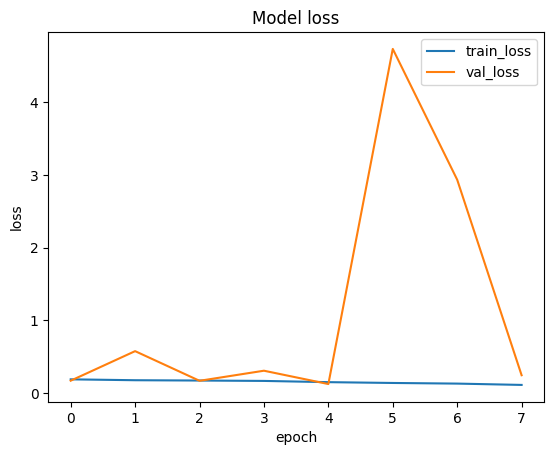

In [ ]:
#plot the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

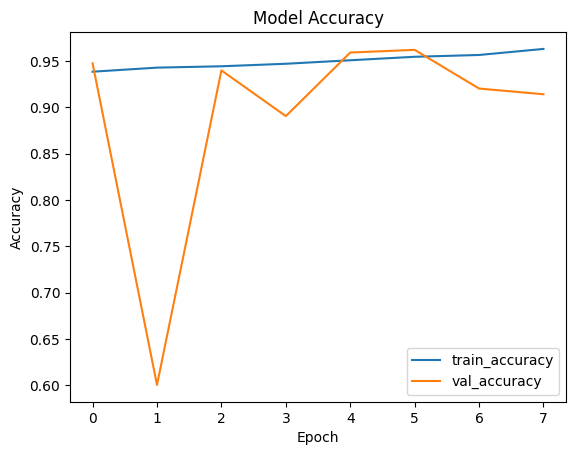

In [ ]:
#plot the accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation and Testing**

In [ ]:
#evaluate model
lenet_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9634 - loss: 0.1453


[0.41822549700737, 0.9651795625686646]

- The losses are less and accuracy is good

In [ ]:
#testing model
def parasite_or_not(x):
  if x>0.5:
    return str("P")
  else:
    return str("U")

- model predictions
- test_dataset.take(1) retrieves one batch from the dataset, but it remains a Dataset object.
- model.predict() expects a NumPy array or Tensor, so test_dataset.take(1) must be properly extracted first.

- [0] extracts the first batch of predictions.
- [0] extracts the first image's prediction score (since it's a binary classification problem, the output is a single probability value).

In [ ]:
#make predictions
print(parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
U


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


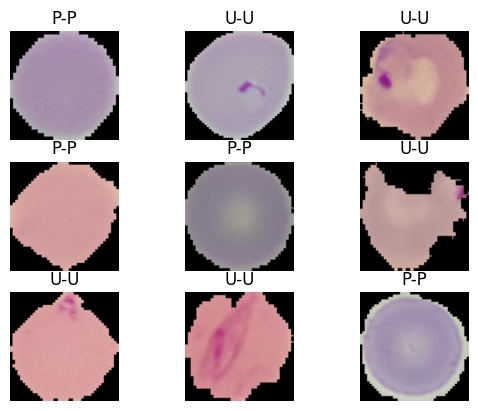

In [ ]:
#Visualize the predictions
for image.label in test_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    #first display what label model predicted and then show its corresponding image
    plt.title(parasite_or_not(label.numpy()[i])+ "-"+ parasite_or_not(lenet_model.predict(image)[i][0]))
    plt.axis("off")
plt.show()


# Loading and Saving model

In [ ]:
#using .keras to save
lenet_model.save("/content/lenet_malaria_detection.keras")

In [ ]:
from tensorflow.keras.models import load_model
# Load the saved model
lenet_loaded_model = load_model("lenet_malaria_detection.keras")
# Check the model architecture
lenet_loaded_model.summary()

# Check if weights are loaded
print("Loaded Model Weights:", len(lenet_loaded_model.weights))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,336,332 (35.62 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

 Optimizer params: 4,668,035 (17.81 MB)

Loaded Model Weights: 26


IT WAS THIS BEFORE SAVING :
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9634 - loss: 0.1453
[0.41822549700737, 0.9651795625686646

In [ ]:
# evaluate the performance of loaded model
# it should be similar as before

#evaluate model
lenet_loaded_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9623 - loss: 0.1174


[0.12207277119159698, 0.9601015448570251]

# Saving to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/